In [20]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as web
from datetime import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
from sklearn.metrics import mean_squared_error

import dash
import plotly.graph_objects as go
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output, State, ALL
import dash_core_components as dcc
import dash_html_components as html
import plotly.express as px
import dash_table
import dash_bootstrap_components as dbc



Using TensorFlow backend.


In [2]:
files = os.listdir("Daten_aufbereitet")
files

['destatis_deutschland_umwelt_beschaeftigte.csv',
 'destatis_deutschland_umwelt_umsatz.csv',
 'destatis_international_energie.csv',
 'destatis_international_forst_fischer.csv',
 'destatis_international_wirtschaft.csv',
 'regulatory_policies_eummr2020.csv',
 'worldbank_climate.csv',
 'worldbank_wdi.csv']

In [3]:
# Primaerenergieverbrauch und CO2-Ausstoß einladen und aufraeumen

df = pd.read_csv("Daten_aufbereitet/" + files[2],
                            sep=";", decimal=",")

df_out = pd.DataFrame()
for i in df.index:
    df_inc = pd.DataFrame()
    jahre = df.iloc[i,3:].T
    df_inc["land"] = [df.iloc[i,0]] * len(jahre)
    df_inc["kennzahl"] = [df.iloc[i,1]] * len(jahre)
    df_inc["einheit"] = [df.iloc[i,2]] * len(jahre)
    df_inc["jahr"] = jahre.index
    df_inc["wert"] = jahre.values
    df_out = df_out.append(df_inc, ignore_index=True)

df_energieverbrauch = df_out
df_energieverbrauch["jahr"] = [dt(int(x),1,1) for x in df_energieverbrauch.jahr]
df_energieverbrauch["wert"] = [np.float(x) for x in df_energieverbrauch.wert]
df_energieverbrauch.head(2)


,land,kennzahl,einheit,jahr,wert
0,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1990-01-01,813.0
1,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1991-01-01,573.0


C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy 

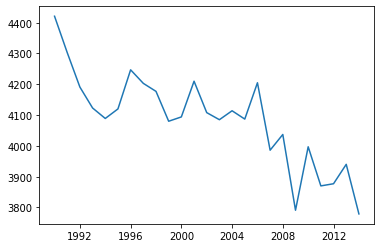

In [4]:
df_plot = df_energieverbrauch.loc[(df_energieverbrauch.land == "Deutschland")
                        & [x.find("Primär") != -1
                           for x in df_energieverbrauch.kennzahl]
                        & (df_energieverbrauch.jahr <= dt(2014,1,1))
                       ]
plt.plot(df_plot.jahr, df_plot.wert)
plt.show()

In [5]:
# Rausfiltern von Laender die einen sehr geringe CO2-Emissionen und geringen Primaerenergieverbrauch haben

laender_filter_df_1 = df_energieverbrauch[df_energieverbrauch.kennzahl == "Primärenergieverbrauch (Rohöleinheiten je Einwoh.)"].groupby(["land"]).mean().sort_values("wert")
laender_filter_df_2 = df_energieverbrauch[df_energieverbrauch.kennzahl == 'Kohlendioxidemissionen je Einwohner'].groupby(["land"]).mean().sort_values("wert")


df_energieverbrauch = df_energieverbrauch.loc[
    [x in laender_filter_df_1[laender_filter_df_1.wert > 0].index 
     and x in laender_filter_df_2[laender_filter_df_2.wert > 0].index
     for x in df_energieverbrauch.land
    ]
]

df_energieverbrauch.head()

,land,kennzahl,einheit,jahr,wert
0,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1990-01-01,813.0
1,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1991-01-01,573.0
2,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1992-01-01,418.0
3,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1993-01-01,412.0
4,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1994-01-01,441.0


In [15]:
# Uebersetzung von Laendernamen

import gettext, pycountry
german = gettext.translation('iso3166', pycountry.LOCALES_DIR, languages=['de'])
german.install()

def trans_country(country_name):
    german_name = _(pycountry.countries.get(name = country_name).name)
    return german_name

trans_country("Germany")

'Deutschland'

In [16]:
reg_int = pd.read_csv("Daten_aufbereitet/regulatory_policies_eummr2020.csv",
                            sep=";", decimal=",", encoding = "=ISO-8859-1")

reg_int.loc[reg_int.COUNTRY == "Czech Republic", "COUNTRY"] = ["Czechia"] * len(reg_int.loc[reg_int.COUNTRY == "Czech Republic", ["COUNTRY"]])
reg_int = reg_int.rename({"IMPLEMENTATIONPERIODSTART": "jahr"}, axis = "columns")
reg_int["land"] = [trans_country(x) for x in reg_int.COUNTRY]

# Rausfiltern von Maßnahmen ohne bekanntes Jahr
reg_int = reg_int[[len(x) == 4 for x in reg_int.jahr]]
reg_int["jahr"] = [dt(int(x),1,1) for x in reg_int.jahr]

reg_int[reg_int.land == "Deutschland"].head(3)

,jahr,STATUSOFIMPLEMENTATION,COUNTRY,NAMEOFPOLICYORMEASURE,GHGSAFFECTED,SINGLEPOLICYORMEASUREORGROUPOFMEASURES,SECTORSAFFECTED,OBJECTIVES_LOOKUP_ONLY4FACETS,OBJECTIVES,ENTITIESRESPONSIBLEFORIMPLEMENTINGTHEPOLICYTYPE,...,ZIEL 2022,ZIEL 2023,ZIEL 2024,ZIEL 2025,ZIEL 2026,ZIEL 2028,ZIEL 2030,ZIEL 2035,Unnamed: 27,land
179,2018-01-01,Implemented,Germany,Adjustment of GHG-Quota and Implementation of ...,CO2,Single,Transport,Transport: Other transport,Transport: Other transport ('Facilitate use of...,National government,...,NaN,"THG-Quote (CO2-Minderung)\n6,5 %",THG-Quote (CO2-Minderung)\n7 %,THG-Quote (CO2-Minderung)\n8 %,NaN,THG-Quote (CO2-Minderung)\n10 %,"THG-Quote (CO2-Minderung)\n14,5 %",THG-Quote (CO2-Minderung)\n22 %,NaN,Deutschland
180,2016-01-01,Implemented,Germany,Energy Saving Order (EnEV),CO2,Single,Energy consumption,Energy consumption: Efficiency improvements of...,Energy consumption: Efficiency improvements of...,National government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deutschland
181,2009-01-01,Implemented,Germany,"Minimum energy performance standards (MEPS, on...",CO2,Single,Energy consumption,Energy consumption: Efficiency improvement of ...,Energy consumption: Efficiency improvement of ...,National government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deutschland


In [201]:
ev_de = df_energieverbrauch.loc[(df_energieverbrauch.land == "Deutschland")
                        & [x.find("Primär") != -1
                           for x in df_energieverbrauch.kennzahl],
                        ["jahr", "wert"]
                       ]

print(df_energieverbrauch[df_energieverbrauch.wert == 0].groupby("jahr").size())

ev_mw = df_energieverbrauch.loc[[x.find("Primär") != -1
                                 for x in df_energieverbrauch.kennzahl]
                                & (df_energieverbrauch.wert > 0)
                               ].groupby("jahr").mean("wert")

# Fuer 2015 ungewoehnlich gering, da nicht so viele Länder gemeldet haben
# wg. missings MW zu gering
# ohne missings MW zu hoch, da nur Staaten gemeldet haben, die hohen Ausstoß/Verbrauch haben
# Nur Durchschnitt aus allen >0 bilden
# -> ab 2015 forecasten

jahr
1990-01-01      2
1991-01-01      1
1992-01-01      3
1993-01-01      3
1994-01-01      2
1995-01-01      1
2000-01-01      1
2001-01-01      1
2002-01-01      1
2003-01-01      1
2004-01-01      1
2005-01-01      1
2006-01-01      1
2008-01-01      1
2009-01-01     31
2010-01-01     31
2011-01-01     30
2012-01-01     31
2013-01-01     30
2014-01-01     37
2015-01-01    133
2016-01-01    167
2017-01-01    167
2018-01-01    167
dtype: int64


In [208]:
co2_de = df_energieverbrauch.loc[(df_energieverbrauch.land == "Deutschland")
                        & [x.find("Kohlen") != -1
                           for x in df_energieverbrauch.kennzahl],
                        ["jahr", "wert"]
                       ]

co2_mw = df_energieverbrauch.loc[[x.find("Kohlen") != -1
                                 for x in df_energieverbrauch.kennzahl]
                                & (df_energieverbrauch.wert > 0)
                               ].groupby("jahr").mean("wert")

co2_mw
# hier nicht so ein starker Bruch

,wert,vorhersage
jahr,,
1990-01-01,5.908589,0.0
1991-01-01,5.827439,0.0
1992-01-01,5.558642,0.0
1993-01-01,5.485185,0.0
1994-01-01,5.844172,0.0
1995-01-01,5.539024,0.0
1996-01-01,5.533939,0.0
1997-01-01,5.669697,0.0
1998-01-01,5.556364,0.0


In [122]:
def feat_pre(sequence, n_timestamp):
    """ generates features from multiple predecessor"""
    X = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp
        if end_ix > len(sequence):
            break
        # i to end_ix as input
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

def forecast_model(series_train, steps_back = 5, epochs = 100):
    X_train = feat_pre(series_train, steps_back)[:-1]
    y_train = series_train[steps_back:].reshape(-1,1)

    # reshape for keras input
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    
    # model: stacked LSTM
    model = keras.models.Sequential()
    model.add(keras.layers.LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(keras.layers.LSTM(50, activation='relu'))
    model.add(keras.layers.Dense(1))
        
    # fitting the model to the train data
    model.compile(loss = "mse", optimizer = "adam")
    history = model.fit(X_train, y_train, epochs = epochs
                    , verbose = 0
                   )

    plt.plot(history.history["loss"])
    plt.title("Training loss")

    plt.show()
    return model

def forecast(model, x_pred, steps = 6):
    y_forecast = []
    for i in range(steps):
        y_new = model.predict(x_pred.reshape(1, x_pred.shape[0],1))[0][0]
        y_forecast.append(y_new)
        x_pred = np.append(x_pred[1:], y_new)
    return np.array(y_forecast)


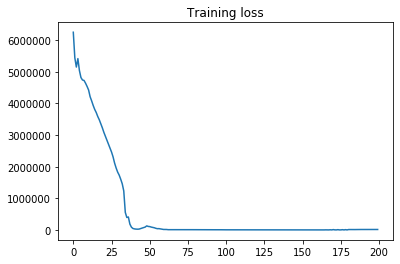

In [264]:
ev_mw = df_energieverbrauch.loc[[x.find("Primär") != -1
                                 for x in df_energieverbrauch.kennzahl]
                                & (df_energieverbrauch.wert > 0)
                               ].groupby("jahr").mean("wert")


series = np.array(ev_mw.wert[:-1])

ev_mw_forecast_model = forecast_model(series,steps_back=5, epochs = 200)
ev_mw_forecast = forecast(mw_forecast_model, series[-5:], steps = 7)

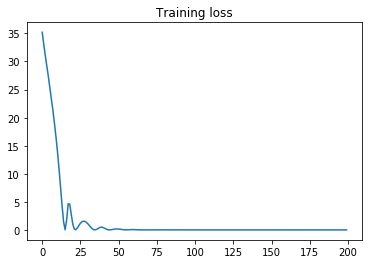

In [265]:
co2_mw = df_energieverbrauch.loc[[x.find("Kohlen") != -1
                                 for x in df_energieverbrauch.kennzahl]
                                & (df_energieverbrauch.wert > 0)
                               ].groupby("jahr").mean("wert")


series = np.array(co2_mw.wert)

co2_mw_forecast_model = forecast_model(series,steps_back=9, epochs = 200)
co2_mw_forecast = forecast(co2_mw_forecast_model, series[-9:], steps = 3)

In [266]:
ev_mw = np.array(list(ev_mw[:-1].wert) + list(ev_mw_forecast))
co2_mw = np.array(list(co2_mw.wert) + list(co2_mw_forecast))

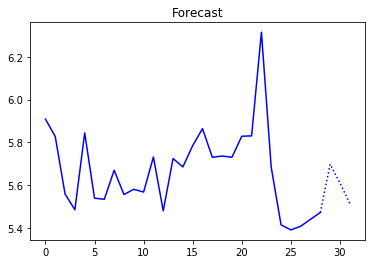

In [269]:
plt.plot(series, color="blue")
plt.plot(range(len(series)-1,len(series)+len(co2_mw_forecast)), [series[-1]] + list(co2_mw_forecast), color = "blue", linestyle = "dotted" )
plt.title("Forecast")
plt.show()

In [70]:
df_energieverbrauch["vorhersage"] = [False] * len(df_energieverbrauch.index)
df_energieverbrauch

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,land,kennzahl,einheit,jahr,wert,vorhersage
0,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1990-01-01,813.0,False
1,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1991-01-01,573.0,False
2,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1992-01-01,418.0,False
3,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1993-01-01,412.0,False
4,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1994-01-01,441.0,False
...,...,...,...,...,...,...
11247,Vanuatu,Kohlendioxidemissionen je Einwohner,t,2014-01-01,0.3,False
11248,Vanuatu,Kohlendioxidemissionen je Einwohner,t,2015-01-01,0.3,False
11249,Vanuatu,Kohlendioxidemissionen je Einwohner,t,2016-01-01,0.3,False
11250,Vanuatu,Kohlendioxidemissionen je Einwohner,t,2017-01-01,0.3,False


In [49]:
# Alle Staaten
df_energieverbrauch.land.unique()

array(['Albanien', 'Belgien', 'Bosnien und Herzegowina', 'Bulgarien',
       'Dänemark', 'Deutschland', 'Estland', 'Finnland', 'Frankreich',
       'Griechenland', 'Irland', 'Island', 'Italien', 'Kroatien',
       'Lettland', 'Litauen', 'Luxemburg', 'Malta', 'Moldau, Republik',
       'Niederlande', 'Nordmazedonien', 'Norwegen', 'Österreich', 'Polen',
       'Portugal', 'Rumänien', 'Russische Föderation', 'Schweden',
       'Schweiz', 'Slowakei', 'Slowenien', 'Spanien', 'Tschechien',
       'Türkei', 'Ukraine', 'Ungarn', 'Vereinigtes Königreich',
       'Weißrussland', 'Zypern', 'Ägypten', 'Algerien', 'Angola',
       'Äquatorialguinea', 'Äthiopien', 'Benin', 'Botsuana', 'Cabo Verde',
       "Cote d'Ivoire", 'Dschibuti', 'Eritrea', 'Eswatini', 'Gabun',
       'Gambia', 'Ghana', 'Guinea-Bissau', 'Kamerun', 'Kenia', 'Komoren',
       'Kongo, Demokratische Republik', 'Kongo, Republik', 'Lesotho',
       'Libyen', 'Marokko', 'Mauritius', 'Mosambik', 'Namibia', 'Niger',
       'Nigeria', 'S

In [81]:
series = df_energieverbrauch.loc[(df_energieverbrauch.land =="Suriname")
                        & (df_energieverbrauch.einheit =="kg")
                        #& (df_energieverbrauch.jahr <=dt(2015,1,1))
                                 ,["jahr","wert"]]

series

,jahr,wert
7540,1990-01-01,1362.0
7541,1991-01-01,NaN
7542,1992-01-01,NaN
7543,1993-01-01,NaN
7544,1994-01-01,NaN
7545,1995-01-01,NaN
7546,1996-01-01,NaN
7547,1997-01-01,NaN
7548,1998-01-01,NaN
7549,1999-01-01,NaN


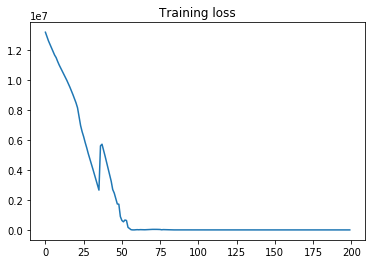

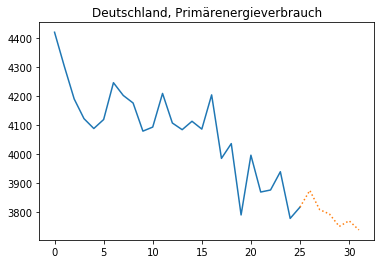

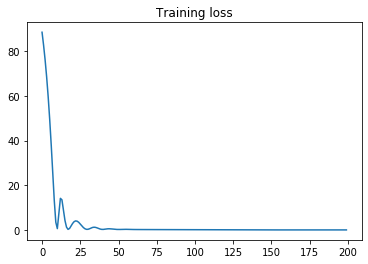

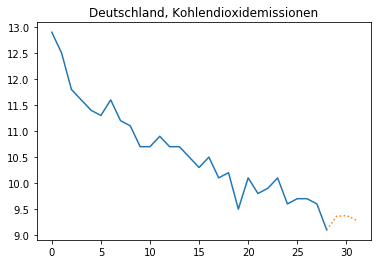

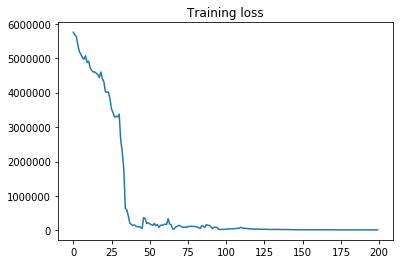

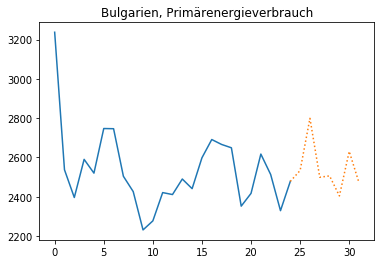

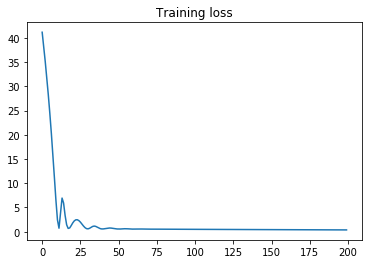

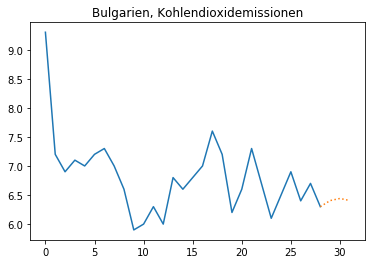

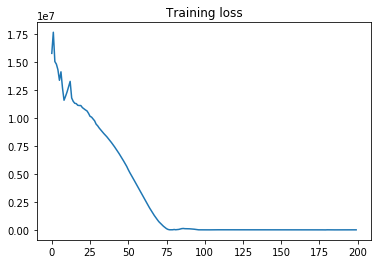

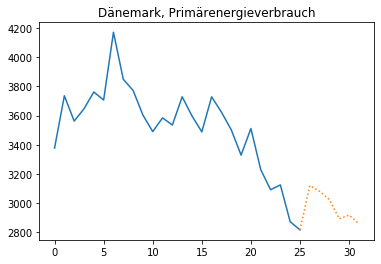

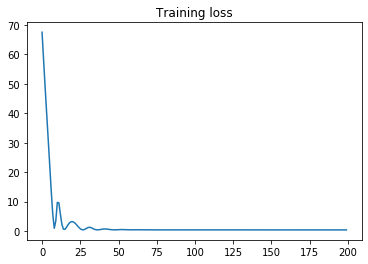

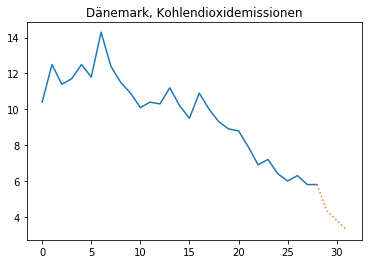

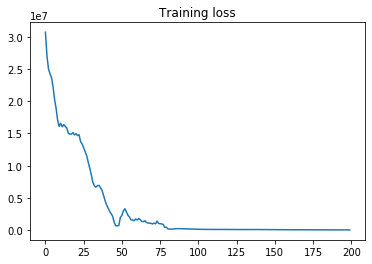

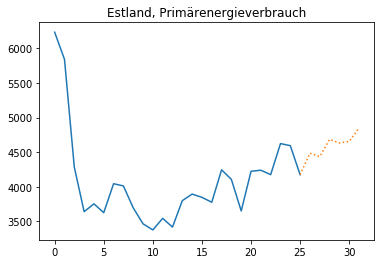

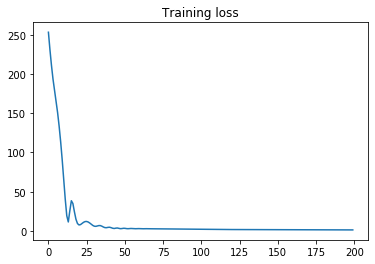

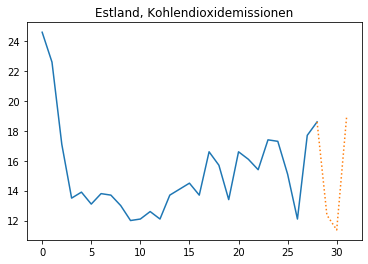

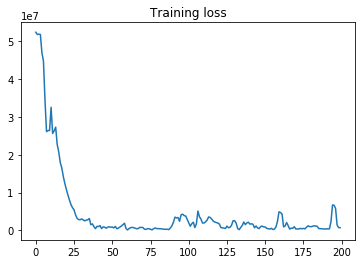

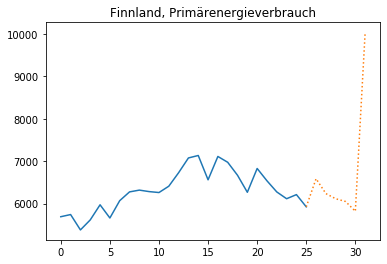

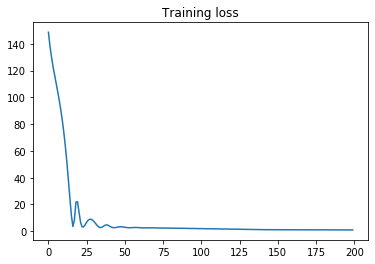

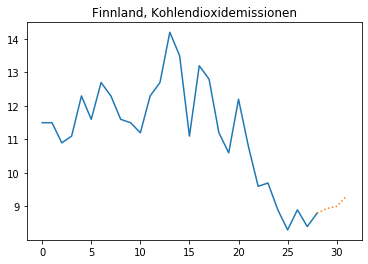

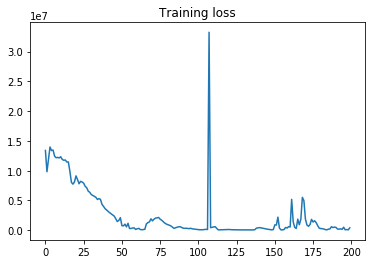

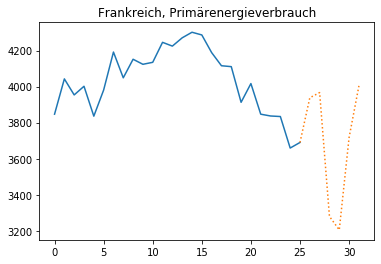

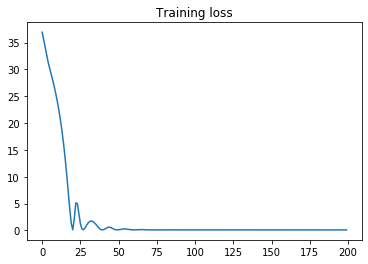

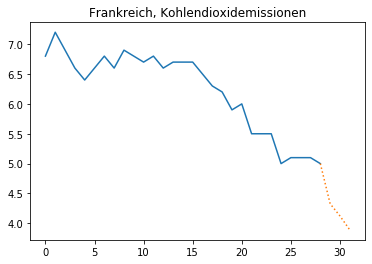

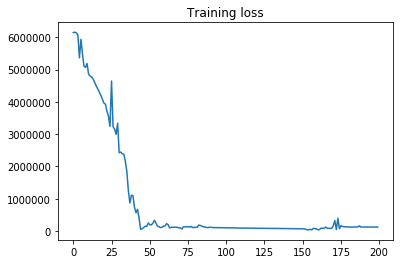

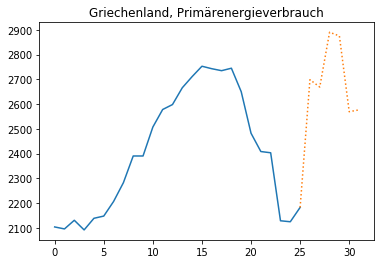

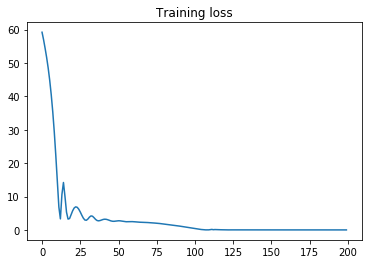

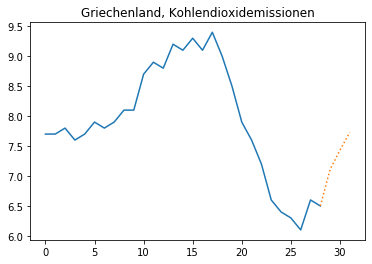

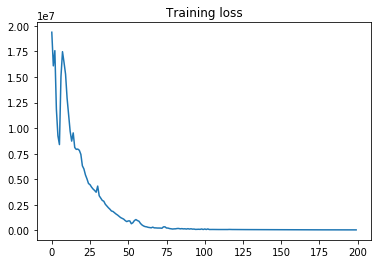

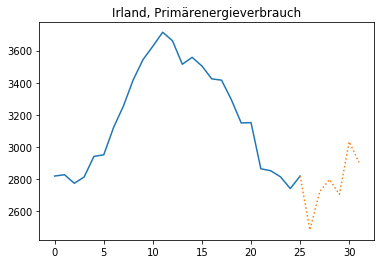

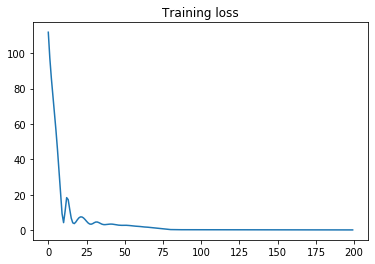

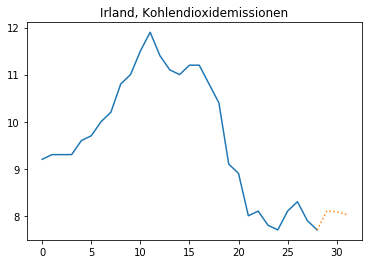

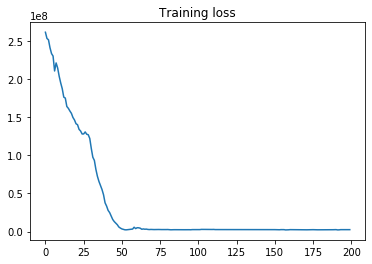

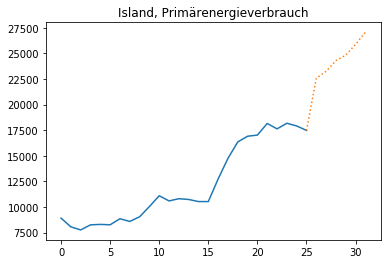

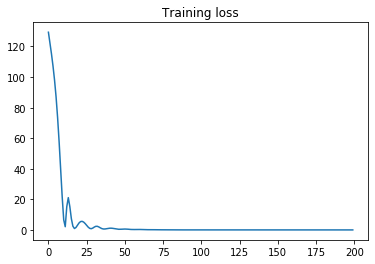

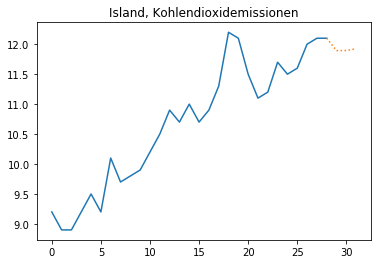

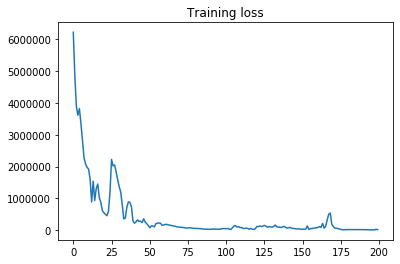

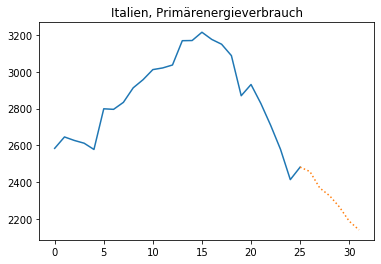

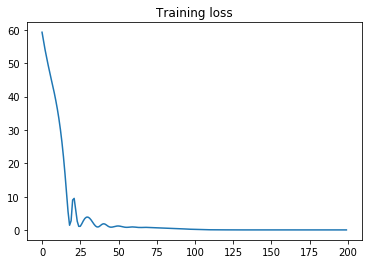

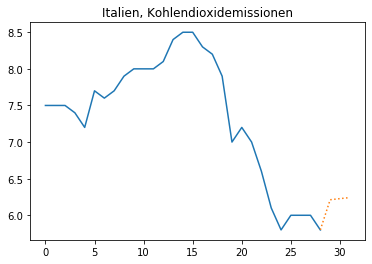

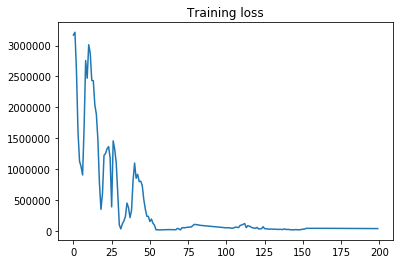

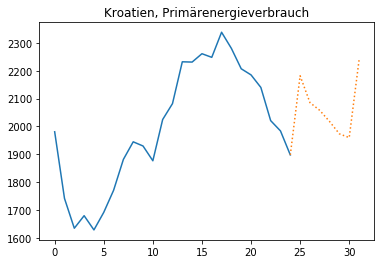

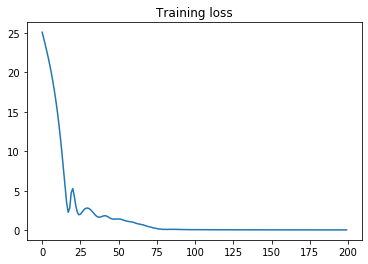

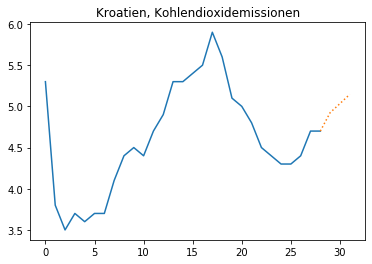

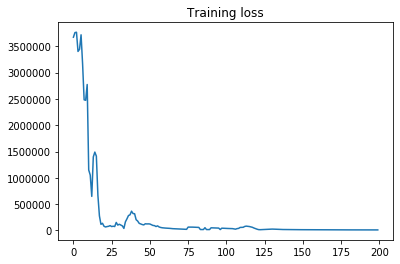

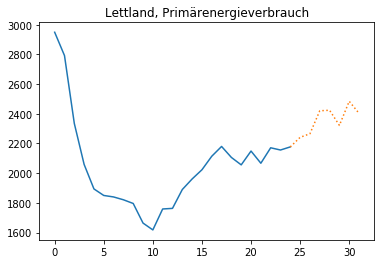

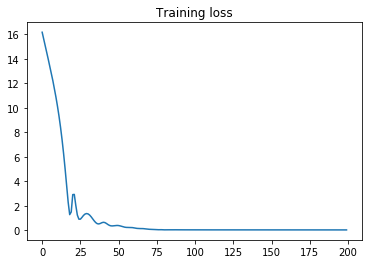

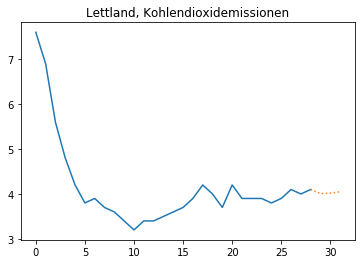

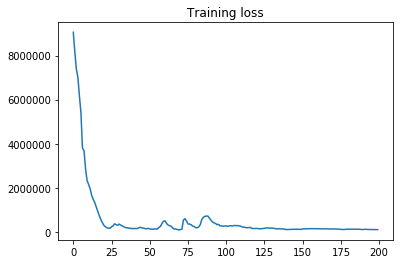

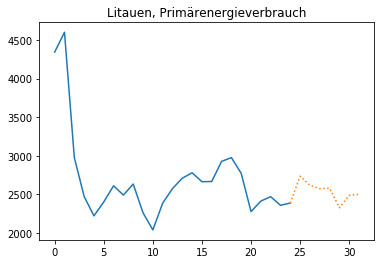

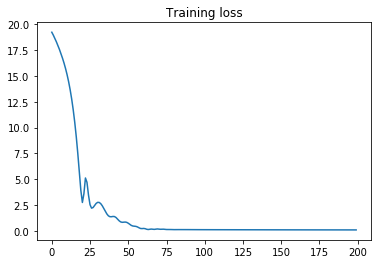

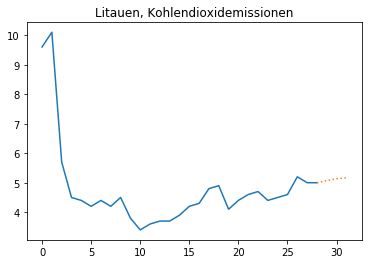

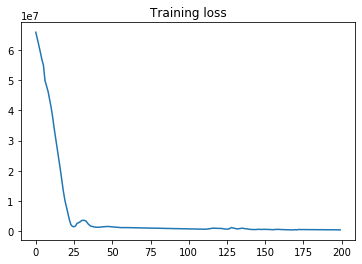

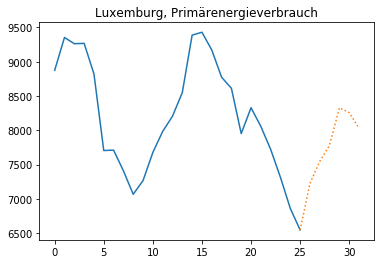

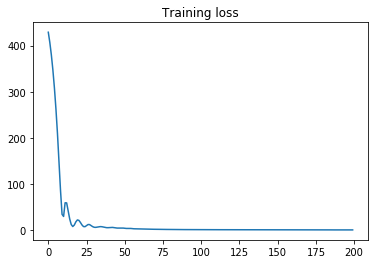

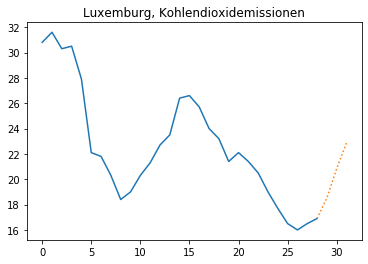

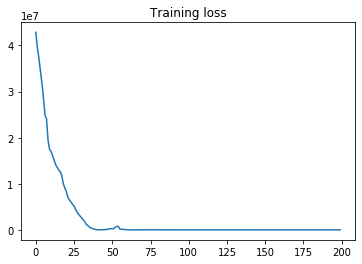

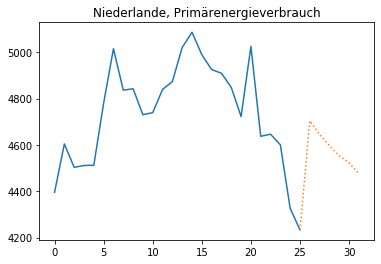

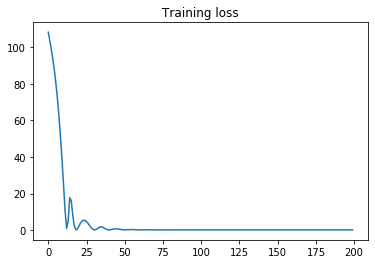

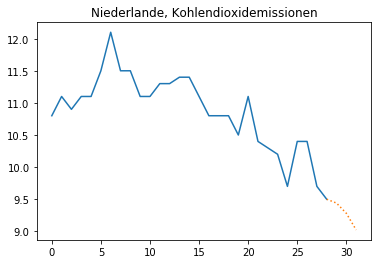

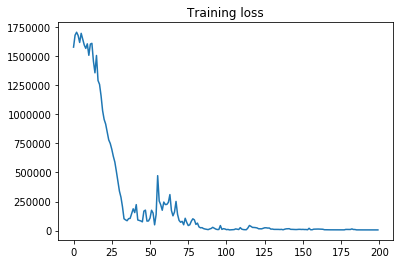

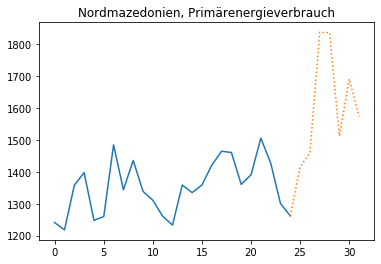

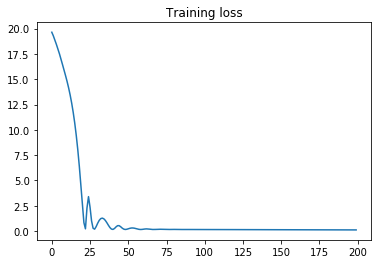

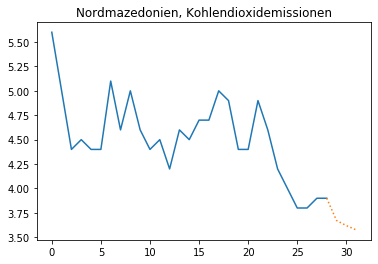

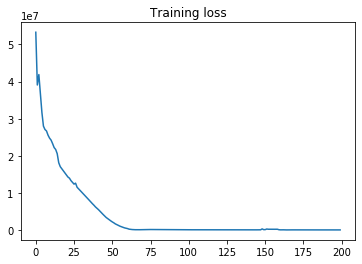

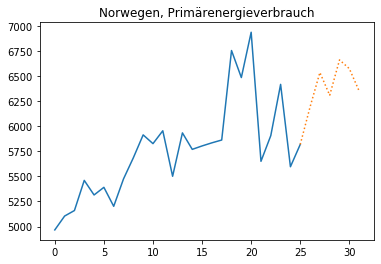

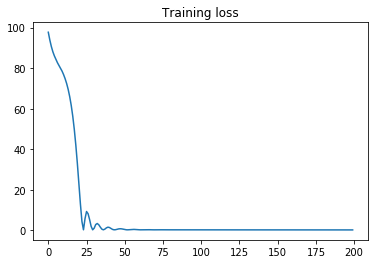

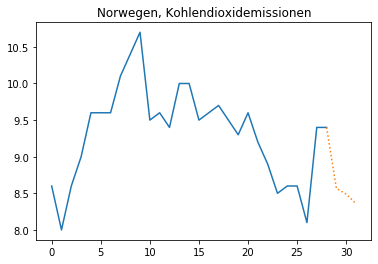

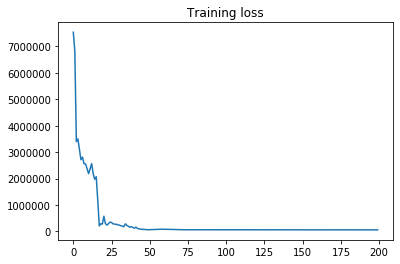

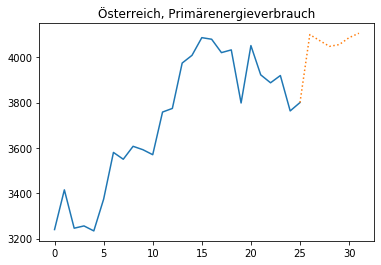

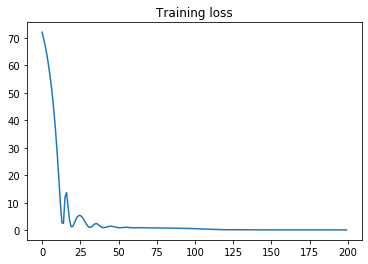

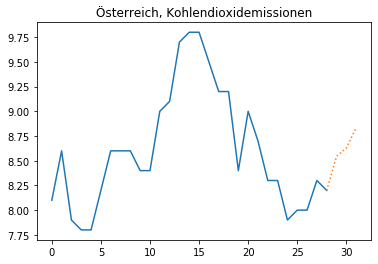

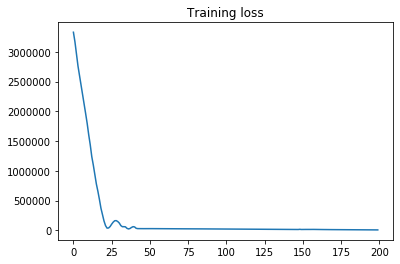

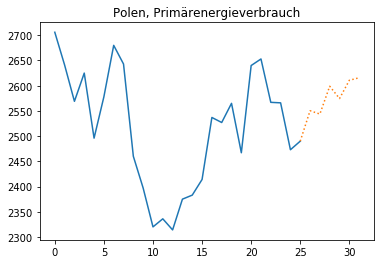

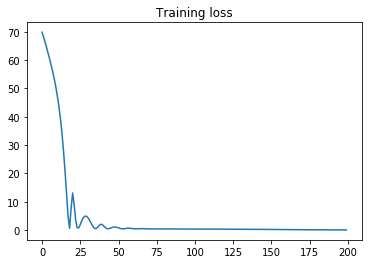

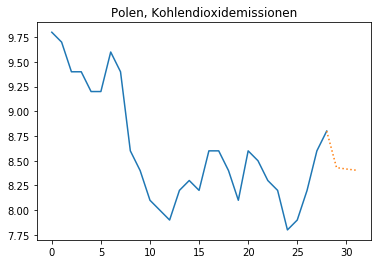

In [276]:
df_energieverbrauch_forecast = df_energieverbrauch


laender = ['Deutschland','Bulgarien',
           'Dänemark',  'Estland', 'Finnland', 'Frankreich',
           'Griechenland', 'Irland', 'Island', 'Italien', 'Kroatien',
           'Lettland', 'Litauen', 'Luxemburg', 'Niederlande', 'Nordmazedonien', 
           'Norwegen', 'Österreich', 'Polen']
einheiten = ["kg", "t"]

for land in laender:
    for einheit in einheiten:
        df_temp = df_energieverbrauch.loc[(df_energieverbrauch.land == land)
                        & (df_energieverbrauch.einheit == einheit)
                        & (df_energieverbrauch.wert != 0)
                                 ,["jahr","wert"]]

        series = np.array(df_temp.wert)
        neue_jahre = pd.Series(pd.date_range(dt(max(df_temp.jahr).year + 1, 1, 1), 
                                     "2021-1-1", freq ="AS-JAN"))

        model = forecast_model(series, 10, epochs = 200)
        forecast_series = forecast(model, series[-10:], len(neue_jahre))

        plt.plot(series)
        plt.plot(range(len(series)-1,len(series)+len(forecast_series)),[series[-1]]+list(forecast_series), linestyle = "dotted")
        if einheit == "kg":
            plt.title(land + ", Primärenergieverbrauch")
        elif einheit == "t":
            plt.title(land + ", Kohlendioxidemissionen")

        plt.show()

        df_neu = pd.DataFrame()
        df_neu["land"] = [land] * len(neue_jahre)
        if einheit == "kg":
            df_neu["kennzahl"] = ["Primärenergieverbrauch (Rohöleinheiten je Einwoh.)"] * len(neue_jahre)
        elif einheit == "t":
            df_neu["kennzahl"] = ["Kohlendioxidemissionen je Einwohner"] * len(neue_jahre)
        df_neu["einheit"] = [einheit] * len(neue_jahre)
        df_neu["jahr"] = neue_jahre
        df_neu["wert"] = forecast_series
        df_neu["vorhersage"] = [True] * len(neue_jahre)

        df_energieverbrauch_forecast = df_energieverbrauch_forecast.append(df_neu,ignore_index = True)

In [174]:
laender

['Deutschland',
 'Bulgarien',
 'Dänemark',
 'Estland',
 'Finnland',
 'Frankreich',
 'Griechenland',
 'Irland',
 'Island',
 'Italien',
 'Kroatien',
 'Lettland',
 'Litauen',
 'Luxemburg',
 'Niederlande',
 'Nordmazedonien',
 'Norwegen',
 'Österreich',
 'Polen']

In [289]:
df_energieverbrauch_forecast["wert_vs_welt"] = [-1] * len(df_energieverbrauch_forecast.index)
df_energieverbrauch_forecast

,land,kennzahl,einheit,jahr,wert,vorhersage,wert_vs_welt
0,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1990-01-01,813.000000,False,-1
1,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1991-01-01,573.000000,False,-1
2,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1992-01-01,418.000000,False,-1
3,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1993-01-01,412.000000,False,-1
4,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1994-01-01,441.000000,False,-1
...,...,...,...,...,...,...,...
9741,Polen,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,2020-01-01,2610.766357,True,-1
9742,Polen,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,2021-01-01,2615.730469,True,-1
9743,Polen,Kohlendioxidemissionen je Einwohner,t,2019-01-01,8.430222,True,-1
9744,Polen,Kohlendioxidemissionen je Einwohner,t,2020-01-01,8.416234,True,-1


In [295]:
for land in laender:
    df_energieverbrauch_forecast.loc[(df_energieverbrauch_forecast.land == land)
                                     & (df_energieverbrauch_forecast.einheit == "kg")
                                     & (df_energieverbrauch_forecast.wert > 0)
                                     ,"wert_vs_welt"] = np.array(df_energieverbrauch_forecast.loc[(df_energieverbrauch_forecast.land == land)
                                     & (df_energieverbrauch_forecast.einheit == "kg")
                                     & (df_energieverbrauch_forecast.wert > 0)
                                     ,"wert"]) / np.array(ev_mw)

    df_energieverbrauch_forecast.loc[(df_energieverbrauch_forecast.land == land)
                                     & (df_energieverbrauch_forecast.einheit == "t")
                                     & (df_energieverbrauch_forecast.wert > 0)
                                     ,"wert_vs_welt"] = np.array(df_energieverbrauch_forecast.loc[(df_energieverbrauch_forecast.land == land)
                                     & (df_energieverbrauch_forecast.einheit == "t")
                                     & (df_energieverbrauch_forecast.wert > 0)
                                     ,"wert"]) / np.array(co2_mw)

In [302]:
df_energieverbrauch_forecast.head()

,land,kennzahl,einheit,jahr,wert,vorhersage,wert_vs_welt
0,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1990-01-01,813.0,False,-1.0
1,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1991-01-01,573.0,False,-1.0
2,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1992-01-01,418.0,False,-1.0
3,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1993-01-01,412.0,False,-1.0
4,Albanien,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1994-01-01,441.0,False,-1.0


In [327]:
reg_int.columns

reg_int_cl = reg_int.iloc[:-7,:-16+1]
reg_int_cl.columns

Index(['jahr', 'STATUSOFIMPLEMENTATION', 'COUNTRY', 'NAMEOFPOLICYORMEASURE',
       'GHGSAFFECTED', 'SINGLEPOLICYORMEASUREORGROUPOFMEASURES',
       'SECTORSAFFECTED', 'OBJECTIVES_LOOKUP_ONLY4FACETS', 'OBJECTIVES',
       'ENTITIESRESPONSIBLEFORIMPLEMENTINGTHEPOLICYTYPE',
       'ENTITIESRESPONSIBLEFORIMPLEMENTINGTHEPOLICY', 'RELATEDUNIONPOLICY',
       'DESCRIPTION', 'LINKTONATIONALREPORT'],
      dtype='object')

In [391]:
colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
] * 200

ds_name_list = [x.split(" ")[0] for x in df_energieverbrauch.kennzahl.unique()]
staaten_list = [x.split("(")[0].split(",")[0] for x in df_energieverbrauch.land.unique()]
staaten_list = laender + list(set(staaten_list) - set(laender))
staaten_list

reg_int_cl = reg_int.iloc[:-7,:-16+1]
reg_int_cl.columns
reg_int_cl = reg_int_cl[['jahr', 'STATUSOFIMPLEMENTATION', 'COUNTRY', 'NAMEOFPOLICYORMEASURE',
       'GHGSAFFECTED', 
       'SECTORSAFFECTED', 'OBJECTIVES_LOOKUP_ONLY4FACETS',
       'DESCRIPTION', 'LINKTONATIONALREPORT']]
reg_int_cl.columns = ['Year', 'Status', 'Country', 'Name',
       'GHGS', 'Sectors', 'Objectives',
       'Description', 'Link']
reg_int_cl = reg_int_cl[['Year', 'Status', 'Country', 'Name',
       'GHGS', 'Sectors', 'Objectives', 'Link']]

ds_beschreibung_list = [

        dcc.Markdown("""
            * In Rohöleinheiten je Einwohner in kg, verglichen mit dem weltweiten Durchschnitt  
            * Die Zeitreihe wurde um einen Nowcast ergänzt, der mithilfe Neuronaler Netze (LSTM) berechnet wurde.
            * Eingezeichnet sind die Jahre, in denen die Implementierung neuer Klimaschutzregulierungen eingeleitet wurde.
        """),

        dcc.Markdown("""
            Je Einwohner in Tonnen, verglichen mit dem weltweiten Durchschnitt
        """)
]

In [329]:
reg_int_cl

,Year,Status,Country,Name,GHGS,Sectors,Objectives,Link
0,2002-01-01,Implemented,Austria,Decrease emissions from F-gases and other prod...,HFC; PFC; SF6; NF3,Industrial processes,Industrial processes: Reduction of emissions o...,http://cdr.eionet.europa.eu/ec/mmr/art04-13-14...
1,1975-01-01,Implemented,Austria,Sustainable Forest Management,CO2,"Land use, land use change and forestry","Land use, land use change and forestry: Enhanc...",http://cdr.eionet.europa.eu/ec/mmr/art04-13-14...
2,1997-01-01,Implemented,Austria,Reduce emissions from waste treatment,CH4; N2O,Code,Waste management/waste: Improved treatment tec...,http://cdr.eionet.europa.eu/ec/mmr/art04-13-14...
3,2004-01-01,Implemented,Belgium,EP-B02 : Energy planning by electricity producers,CO2,BelgiumSingle,Energy consumption: Demand management/reductio...,http://cdr.eionet.europa.eu/be/eu/mmr/art04-13...
4,2004-01-01,Implemented,Belgium,EC-A03 : Energy performance and certificate of...,CO2,BelgiumSingle,Energy consumption: Efficiency improvements of...,http://cdr.eionet.europa.eu/be/eu/mmr/art04-13...
...,...,...,...,...,...,...,...,...
449,2009-01-01,Implemented,United Kingdom,Ozone depleting substances regulation,HFC,Industrial processes,Industrial processes: Reduction of emissions o...,http://cdr.eionet.europa.eu/gb/eu/mmr/art04-13...
450,2015-01-01,Implemented,United Kingdom,F-gas regulation (2015),HFC; PFC; SF6,Industrial processes; Other Sectors,Industrial processes: Reduction of emissions o...,http://cdr.eionet.europa.eu/gb/eu/mmr/art04-13...
451,2008-01-01,Implemented,United Kingdom,Sustainable Energy-Using Products â Pre-Low ...,CO2,Energy consumption,Energy consumption: Efficiency improvement of ...,http://cdr.eionet.europa.eu/gb/eu/mmr/art04-13...
452,1999-01-01,Implemented,United Kingdom,Forestry Act Felling Licence Regulations and E...,CO2,"Land use, land use change and forestry","Land use, land use change and forestry: Preven...",http://cdr.eionet.europa.eu/gb/eu/mmr/art04-13...


In [352]:
df.sort_values("jahr")

,jahr,STATUSOFIMPLEMENTATION,COUNTRY,NAMEOFPOLICYORMEASURE,GHGSAFFECTED,SINGLEPOLICYORMEASUREORGROUPOFMEASURES,SECTORSAFFECTED,OBJECTIVES_LOOKUP_ONLY4FACETS,OBJECTIVES,ENTITIESRESPONSIBLEFORIMPLEMENTINGTHEPOLICYTYPE,...,ZIEL 2022,ZIEL 2023,ZIEL 2024,ZIEL 2025,ZIEL 2026,ZIEL 2028,ZIEL 2030,ZIEL 2035,Unnamed: 27,land
41,1960,Planned,Belgium,Fossil exit for heating,CO2,Single,BelgiumSingle,Energy consumption: Demand management/reduction,Energy consumption: Demand management/reduction,Regional entities,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Belgien
200,1970,Planned,Iceland,AG02 - Reduced use of non-organic fertilizers,N2O,Single,Agriculture,Agriculture: Reduction of fertilizer/manure us...,Agriculture: Reduction of fertilizer/manure us...,National government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Island
240,1974,Planned,Italy,Energy audits in companies,CO2,Single,Energy consumption,Energy consumption: Efficiency improvement in ...,Energy consumption: Efficiency improvement in ...,Research institutions,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Italien
392,1975,Implemented,Slovenia,Regulations on the energy efficiency and renew...,CO2,Single,Energy consumption; Energy supply,Energy consumption: Efficiency improvements of...,Energy consumption: Efficiency improvements of...,National government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Slowenien
306,1976,Implemented,Malta,Agriculture Waste Management in the Maltese Is...,CH4; N2O,Single,Agriculture,Agriculture: Reduction of fertilizer/manure us...,Agriculture: Reduction of fertilizer/manure us...,National government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Malta
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,2021,Planned,Italy,Certification of biofuel sustainability,CO2,Single,Transport,Transport: Low carbon fuels/electric cars,Transport: Low carbon fuels/electric cars,National government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Italien
325,2021,Implemented,Poland,National Programme for Municipal Waste Water T...,CH4; N2O; CO2,Single,Waste management/waste,Waste management/waste: Improved wastewater ma...,Waste management/waste: Improved wastewater ma...,"Companies/business/industrial association, N...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Polen
280,2021,Implemented,Luxembourg,Industrial processes - F-gas related emissions...,HFC; PFC; SF6,Single,Industrial processes,Industrial processes: Reduction of emissions o...,Industrial processes: Reduction of emissions o...,National government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Luxemburg
182,2022,Implemented,Germany,"Minimum energy performance standards (MEPS), I...",CO2,Single,Energy consumption,Energy consumption: Efficiency improvement in ...,Energy consumption: Efficiency improvement in ...,National government,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Deutschland


In [353]:
df = reg_int.sort_values(by='jahr')
df["jahr"] = [x.year for x in reg_int.jahr]
df = df.sort_values("jahr")
fig_policies = px.choropleth(data_frame=df, locationmode='country names', locations='COUNTRY', color='SECTORSAFFECTED', scope='europe', animation_frame='jahr' )


In [354]:
fig_policies.show()

In [345]:
df0

,land,kennzahl,einheit,jahr,wert,vorhersage,wert_vs_welt
290,Deutschland,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1990-01-01,4421.000000,False,2.155394
291,Deutschland,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1991-01-01,4303.000000,False,1.858269
292,Deutschland,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1992-01-01,4191.000000,False,1.879102
293,Deutschland,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1993-01-01,4123.000000,False,1.860310
294,Deutschland,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,1994-01-01,4089.000000,False,1.853780
...,...,...,...,...,...,...,...
9574,Deutschland,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,2020-01-01,3770.909180,True,1.368515
9575,Deutschland,Primärenergieverbrauch (Rohöleinheiten je Einw...,kg,2021-01-01,3739.344238,True,1.347766
9576,Deutschland,Kohlendioxidemissionen je Einwohner,t,2019-01-01,9.361004,True,1.642903
9577,Deutschland,Kohlendioxidemissionen je Einwohner,t,2020-01-01,9.376010,True,1.671252


In [343]:
var

'wert_vs_welt'

In [385]:
df0 = df_primaerenergie_fore.loc[(df_primaerenergie_fore.land == "Deutschland") 
                                     & (df_primaerenergie_fore.wert_vs_welt.notna())
                                     & (df_primaerenergie_fore.wert > 0 )
                                     & [x.find("Kohlen") != -1
                                         for x in df_primaerenergie_fore.kennzahl]
                                     #& (df_primaerenergie_fore.jahr != 2015)
                                     #& (df_primaerenergie_fore.jahr <= 2022)
                                    ]
df_temp = df0
fig0 = go.Figure()
fig0.add_trace(
    go.Scatter(x = df_temp[np.logical_not(df_temp.vorhersage)].jahr, y = df_temp.loc[np.logical_not(df_temp.vorhersage), var],
        mode="lines+markers", name = "Deutschland", line = dict(color = colors[0])
))

#fig0.add_trace(
#    go.Scatter(x = df_temp[df_temp.vorhersage].jahr, y = df_temp.loc[df_temp.vorhersage,var],
#        mode="lines+markers", line=dict(color = colors[0],dash = "dash"), 
#                                        showlegend=False
#))

#fig0.add_vline(x = dt(2000,1,1), line = dict(color = colors[val+4], dash = "dash"))
fig0.add_vline(x = reg_jahre[2], line = dict(color = colors[val+4], dash = "dash"))

for val in [0,1,3]:
    land = staaten_list[val]
    reg_jahre = reg_int[reg_int.land == land].jahr.unique()
    for j in reg_jahre:
        fig0.add_vline(x = pd.Timestamp(j), line = dict(color = colors[val+4], dash = "dash"))


fig0.update_layout(legend_title_text='Staaten', showlegend=True)


fig0.show()

In [422]:
app_track_df.head(20)

,staat,n_clicks
0,Deutschland,0
1,Bulgarien,0
2,Dänemark,0
3,Estland,0
4,Finnland,0
5,Frankreich,0
6,Griechenland,0
7,Irland,0
8,Island,0
9,Italien,0


In [438]:
# Tracken der App Activitaet
# 1. Neue CSV erstellen
zuruecksetzen = False

if "app_track.csv" not in os.listdir() or zuruecksetzen:
    app_track_df = pd.DataFrame({"staat": staaten_list, "n_clicks": [0]*len(staaten_list)})
    app_track_df.to_csv("app_track.csv", sep = ";", index = False, encoding = "=ISO-8859-1")

In [595]:
# Click-Zahlen einlesen
# Staaten nach hohen Click-Zahlen sortieren
# mit Wahrscheinlichkeit eps_change_3 den dritten Eintrag aendern auf weniger ausgewaehlten Staat
# dadurch kann das Nutzerverhalten erforscht werden
# und gleichzeitig wird mit einer hohen Wahrscheinlichkeit das Nutzerinteresse bedient

from random import random, randint, sample, seed

app_track_df = pd.read_csv("app_track.csv", sep = ";", encoding = "=ISO-8859-1")

app_track_df = app_track_df.sort_values("n_clicks", ascending = False, ignore_index=True)

#seed(3)
r3 = random()
print(r3)

eps_change_3 = .3

if r3 < eps_change_3:
    random_row = sample(list(app_track_df.loc[app_track_df.n_clicks >= 2].index[5:]),1)
    #print(random_row)
    app_track_df = app_track_df.reindex([0,1] + random_row + list(set(range(2, len(app_track_df))) - set(random_row)))
elif r3 < eps_change_3 + .1:
    random_row = sample(list(app_track_df.loc[app_track_df.n_clicks >= 2].index[5:]),2)
    #print(random_row)
    app_track_df = app_track_df.reindex([0,1] + random_row + list(set(range(2, len(app_track_df))) - set(random_row)))

staaten_list = list(app_track_df.staat)
app_track_df[app_track_df.n_clicks > 1]

0.39713457702896093


,staat,n_clicks
0,Deutschland,127
1,Frankreich,108
7,Litauen,31
8,Bulgarien,22
2,Norwegen,70
3,Italien,41
4,Polen,35
5,Island,32
6,Österreich,32
9,Luxemburg,17


In [597]:
df_primaerenergie_fore = df_energieverbrauch_forecast
var = "wert_vs_welt"
df0 = df_primaerenergie_fore.loc[(df_primaerenergie_fore.land == "Deutschland") 
                                     & (df_primaerenergie_fore.wert_vs_welt.notna())
                                     & (df_primaerenergie_fore.wert > 0 )
                                     & [x.find("Primär") != -1
                                         for x in df_primaerenergie_fore.kennzahl]
                                ]

df_temp = df0
fig0 = go.Figure()
fig0.add_trace(
    go.Scatter(x = df_temp[np.logical_not(df_temp.vorhersage)].jahr, y = df_temp.loc[np.logical_not(df_temp.vorhersage), var],
        mode="lines+markers", name = "Deutschland", line = dict(color = colors[0])
))

fig0.add_trace(
    go.Scatter(x = df_temp[df_temp.vorhersage].jahr, y = df_temp.loc[df_temp.vorhersage,var],
        mode="lines+markers", line=dict(color = colors[0],dash = "dash"), 
                                        showlegend=False
))
fig0.update_layout(legend_title_text='Staaten', showlegend=True)

#reg_jahre = reg_int[reg_int.land == "Deutschland"].jahr.unique()
#for j in reg_jahre:
#    fig0.add_vline(x = int(j), line_color = colors[1], line_width=1, line_dash="dash"
#                 )

# App starten
app = JupyterDash(__name__,
                 external_stylesheets=[
                    dbc.themes.CYBORG#BOOTSTRAP#CYBORG#DARKLY#BOOTSTRAP
                     #"https://codepen.io/chriddyp/pen/bWLwgP.css"
                    #"https://codepen.io/chriddyp/pen/bWLwgP.css"
                 ])


app.layout = dbc.Container([
    #  AutoUserValiDash Alternativ: Dashbot/ Userdash/ Com(munity)dash/ Anwenderdash
    dcc.Markdown("""
        # EcoDrive
        
        **Das automatisiert nutzerfreundliche Umwelt-Dashboard**
        
        *Destatis Hackathon 2021 - Beitrag des Teams "A for Algorithm"*
    """),
    
    html.Br(),
    
    dbc.Row([
        dbc.Col([
            dbc.Card([
                html.H3("Klimapolitik und ihre Effektivität im Überblick"),
                dbc.Row([
                    dbc.Col([
                        html.P("Kennzahlen:"),
                        
                        dcc.Dropdown(
                            id = "waehle_kennzahl",
                            options = [{"label": x, "value": i}
                                for i, x in enumerate(ds_name_list)],
                            value = 0, clearable = False
                        ),
                        
                    ]),
                    dbc.Col([
                        html.P("Staaten:"),
                        
                        dcc.Dropdown(
                            id = "waehle_region",
                            options = [{"label": x, "value": i}
                                for i, x in enumerate(staaten_list)
                                ],
                            value = [0,1,2],
                            multi = True,
                            clearable = False
                        ),                        
                    ]),
                    dbc.Col([
                        html.Hr(),
                        dcc.Checklist(
                            id = "regulierung_anzeigen",
                            options = [{"label": "Regulierungen anzeigen", "value": 0},
                              ],
                            value = [0]
                        ),                        
                    ]),
                    
            ]),
            html.Hr(),
            dbc.Row([
                dbc.Col([], id="beschreibung_kennzahl")
            ]),
            dbc.Row([
                dbc.Col([
                dbc.Col([dcc.Graph(figure = fig0, id = "graph_reg"),
                ]),]),
            ]),
            html.Hr(),
            dcc.Markdown("**Übersicht über Regulierungen**"),
                
            dbc.Row([dbc.Col([dash_table.DataTable(
                id ="tabelle",
                columns=[{"name": i, "id": i,  
                                  #"selectable": True
                                  "hideable": True
                                 } 
                                  for i in reg_int_cl.columns
                                ],
        
                data = reg_int_cl[reg_int_cl.Country == "Germany"].sort_values(["Country", "Year"]).to_dict('records'),
                page_current= 0,
                page_size= 3,
                filter_action="native",
                sort_action="native",
                sort_mode="multi",
                style_cell = {
                    "color" : "black",
                            "whiteSpace":"normal",
                            "height": "auto",
                            "textAlign":"left"
                }
            ),])]),
                ]),
                
        ]),
    ]),


    html.Hr(),
    
    dbc.Row([
        dbc.Col([
            dbc.Card([
                html.H3("Maßnahmen im Zeitverlauf"),
                html.Hr(),
                html.P("Aufgeschlüsselt nach Staat und Sektor"),
                  dbc.Row([
                dbc.Col([
                dbc.Col([dcc.Graph(figure = fig_policies, style={'width': '90vh', 'height': '60vh'}),
                ]),]),
            ]),
            ])
        ]),      
    ]),

    html.Hr(),
    
#    dbc.Row([
#        dbc.Col([
#            dbc.Card([
#                html.H3("Heatmap - Phase/Staat - jährlich mittl. Auswirkung"),
#                html.Hr(),html.Hr(),html.Hr(),html.Hr(),html.Hr(),html.Hr(),html.Hr(),html.Hr(),html.Hr(),html.Hr(),
#            ])
#        ]),      
#    ]),
])

@app.callback(
    Output("beschreibung_kennzahl", "children"),
    Input("waehle_kennzahl", "value"),
    )
def beschreibung_aendern(value):
    return ds_beschreibung_list[int(value)]

@app.callback(
    Output("graph_reg", "figure"),
    Input("waehle_kennzahl", "value"),
    Input("waehle_region", "value"),
#    Input("regulierung_anzeigen", "value")
)
def aktualisiere_graph1(value1, 
                        value2, 
                        #value3
                       ):
    if value2 is not None:
        if value1 == 0:
            fig = go.Figure()
            for val in value2:
                land = staaten_list[val]
                
                # track activity
                global app_track_df
                app_track_df.loc[app_track_df.staat == land, "n_clicks"] +=1

                
                
                df = df_primaerenergie_fore.loc[(df_primaerenergie_fore.land == land)
                                     & (df_primaerenergie_fore.wert_vs_welt.notna())
                                     & (df_primaerenergie_fore.wert > 0 )
                                     & [x.find("Primär") != -1
                                         for x in df_primaerenergie_fore.kennzahl]                                                
                                     #& (df_primaerenergie_fore.wert_vs_welt.notna())
                                     #& (df_primaerenergie_fore.jahr != 2015)
                                     #& (df_primaerenergie_fore.jahr <= 2022)          
                                    ]
                
                fig.add_trace(
                    go.Scatter(x = df[np.logical_not(df.vorhersage)].jahr,
                               y = df.loc[np.logical_not(df.vorhersage), var],
                               mode="lines+markers", 
                               name = land, line = dict(color = colors[val+4])
                              )
                )
                fig.add_trace(
                    go.Scatter(x = df[df.vorhersage].jahr,
                               y = df.loc[df.vorhersage, var],
                               mode="lines+markers", 
                               name = land, line = dict(color = colors[val+4],dash = "dash"),
                               showlegend=False
                              )
                )
                reg_jahre = reg_int[reg_int.land == land].jahr.unique()
                for j in reg_jahre:
                    fig.add_vline(x = j, line = dict(color = colors[val+4],dash = "dash"))
                #    txt =""
                #    for i, t in enumerate(reg_int.loc[(reg_int.land == land)&(reg_int.jahr == j),"id"]):
                 #       txt += ", " + t
                #        if i % 3 == 0: txt += "\n"
                #    fig.add_annotation(x=j, y =2.5, text=txt, textangle = 90, showarrow=False)
        if value1 == 1:
            df = ds_list[int(value1)][[int(x) <= 2014 for x in (ds_list[int(value1)].jahr)]
                                 ].query("land in "+str([staaten_list[i] for i in value2]))
            df = df_primaerenergie_fore.loc[(df_primaerenergie_fore.land == land)
                                     & (df_primaerenergie_fore.wert_vs_welt.notna())
                                     & (df_primaerenergie_fore.wert > 0 )
                                     & [x.find("Kohlen") != -1
                                         for x in df_primaerenergie_fore.kennzahl]                                                
                                     #& (df_primaerenergie_fore.wert_vs_welt.notna())
                                     #& (df_primaerenergie_fore.jahr != 2015)
                                     #& (df_primaerenergie_fore.jahr <= 2022)          
                                    ]            
            df["jahr_num"] = [int(x) for x in df.jahr]
            fig = px.line(df, x = "jahr_num", 
                      y="wert_vs_welt",
                      color = "land")

        for val in value2:
            land = staaten_list[val]
            reg_jahre = reg_int[reg_int.land == land].jahr.unique()
            for j in reg_jahre:
                j = pd.Timestamp(j)
                if j.year >= 1990:
                    fig.add_vline(x = j, line = dict(color = colors[val+4],dash = "dash"))
        
        fig.update_layout(legend_title_text='Staaten', showlegend=True)
        #app_track_df.to_csv("app_track.csv", sep = ";", index = False)
        return fig
    

# App ausfuehren
if __name__ == '__main__':
    app.run_server(
        #mode="inline",
        #debug=True, 
        port=40
    )

Dash app running on http://127.0.0.1:40/


In [600]:
app_track_df.to_csv("app_track.csv", sep = ";", index = False, encoding = "=ISO-8859-1")
app_track_df[app_track_df.n_clicks > 0 ]

,staat,n_clicks
0,Deutschland,143
1,Frankreich,113
7,Litauen,36
8,Bulgarien,23
2,Norwegen,73
3,Italien,42
4,Polen,36
5,Island,32
6,Österreich,32
9,Luxemburg,17


In [ ]:
# TODO
# FIX: CO2 Ausstoß


# Done
# df_energieverbrauch.jahr in dt umwandeln
# 1. Datensaetze einladen:
#   a. CO2-Ausstoß
#   b. Primärenergieverbrauch
#   c. Policies
# 2. Bereinigen
# 3. Forecast (LSTM), nur wichtige Länder, z.B. in EU
#    a. MW fortgesetzt
#    b. daraus Prognose-Tool erstellen
#    c. damit wichtige Laender, evtl. nur DE, FR, etc...
#    d. wert_vs_welt berechnen
# 4. App starten
# (5. Nutzung der App tracken)
# (6. eps-greedy, softmax um Darstellung zu optimieren)